# A simple Lattice Bolzmann scheme in 2D square region

LBM direction (ref: http://sites.psu.edu/sihongyan/pflbm/):

    6 2 5
    3 0 1
    7 4 8

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from numba import jit

## Initialization

In [2]:
# == constants ==
nx = 200  # points in x direction
ny = 60  # points in y direction
nq = 9  # D2Q9 LBM
omega = 1 # relaxation parameters, between [0, 2]
force = 3e-9  # external forcing in x direction

cs2 = 1/3  # sound speed squared
cs = np.sqrt(cs2)  # sound speed
cs4 = cs2**2

#  weights for D2Q9
w = np.array([4/9,
     1/9 ,1/9, 1/9, 1/9,
     1/36, 1/36, 1/36, 1/36])

# == prognostic variables ==

# Is (ny, nx, nq) a more efficient memory layout than (nq, ny, nx) ?
# +2 is for buffering regions
f = np.zeros((ny+2, nx+2, nq))  # particle population. 
feq = np.zeros((ny+2, nx+2, nq))  # The equilibrium distribution

ux = np.zeros((ny+2, nx+2))  #  macroscopic velocity in x
uy = np.zeros((ny+2, nx+2))  #  macroscopic velocity in y
rho = np.zeros((ny+2, nx+2))  # macroscopic density (sum of particle in all directions)

## The LBM solver code
Functions are written in C-like form. Only manipulating pointers. Do not return. Use loop insteads of vectorization.

In [3]:
@jit
def macroscopic(f, rho, ux, uy):
    '''
    Computing macroscopic variables from population
    
    Adapted from  `subroutine hydrovar` in Sauro Succi's Fortran code
    
    Input
    -----
    f: 3D numpy array, population
    
    Output
    ------
    rho: 2D numpy array, density
    ux, uy: 2D numpy array, velocity
    '''
    
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            
            rho[j, i] = f[j, i, :].sum()
            
            # unroll loop explictly to avoid summing over zeros
            ux[j, i] = (f[j, i, 1] + f[j, i, 5] + f[j, i, 8] 
                       - f[j, i, 3] - f[j, i, 6] - f[j, i, 7]
                      )/rho[j, i]
            
            uy[j, i] = (f[j, i, 2] + f[j, i, 5] + f[j, i, 6] 
                       - f[j, i, 4] - f[j, i, 7] - f[j, i, 8]
                      )/rho[j, i]
            

In [4]:
@jit
def apply_forcing(f, force):
    '''
    Apply external forcing
    
    Adapted from `subroutine force` in Sauro Succi's Fortran code
    
    Input
    -----
    f: 3D numpy array, population before forcing
    force: float, global constant force in x direction
    
    Output
    ------
    f: 3D numpy array, population after forcing
    '''
    
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            
            f[j, i, 1] += force
            f[j, i, 5] += force
            f[j, i, 8] += force

            f[j, i, 3] -= force
            f[j, i, 6] -= force
            f[j, i, 7] -= force

In [5]:
@jit
def equilibrium(rho, ux, uy, feq):   
    '''
    Computing equilibrium population from macroscopic variables
    
    Adapted from `subroutine equili` in Sauro Succi's Fortran code
    
    Input
    -----
    rho: 2D numpy array, density
    ux, uy: 2D numpy array, velocity
    
    Output
    ------
    feq: 3D numpy array, equilibrium population
    '''
    
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            
            # == expressions that can be reused ==  
            # Comments are the corresponding variable names in Sauro Succi's Fortran code
            ux_d_cs2 = ux[j, i] / cs2  # ui
            uy_d_cs2 = uy[j, i] / cs2  # vi
            ux2_d_2cs4 = ux[j, i]**2 / (2*cs4)  # u2
            uy2_d_2cs4 = uy[j, i]**2 / (2*cs4)  # v2
            
            v2_d_2cs2 = (ux[j, i]**2 + uy[j, i]**2) / (2*cs2)  # sumsq (v = velocity magnitude)
            v2_d_sp = v2_d_2cs2 * (1.0 - cs2) / cs2  # sumsq2  (sp = special)
            uxuy_d_cs4 = ux_d_cs2 * uy_d_cs2  # uv
        
            # == computing equilibrium ==
            feq[j, i, 0] = rho[j, i]*w[0]*(1 - v2_d_2cs2)

            feq[j, i, 1] = rho[j, i]*w[1]*(1 - v2_d_2cs2 + ux_d_cs2 + ux2_d_2cs4)
            feq[j, i, 2] = rho[j, i]*w[2]*(1 - v2_d_2cs2 + uy_d_cs2 + uy2_d_2cs4)
            feq[j, i, 3] = rho[j, i]*w[3]*(1 - v2_d_2cs2 - ux_d_cs2 + ux2_d_2cs4)
            feq[j, i, 4] = rho[j, i]*w[4]*(1 - v2_d_2cs2 - uy_d_cs2 + uy2_d_2cs4)

            feq[j, i, 5] = rho[j, i]*w[5]*(1 + v2_d_sp + ux_d_cs2 + uy_d_cs2 + uxuy_d_cs4)
            feq[j, i, 6] = rho[j, i]*w[6]*(1 + v2_d_sp - ux_d_cs2 + uy_d_cs2 - uxuy_d_cs4)
            feq[j, i, 7] = rho[j, i]*w[7]*(1 + v2_d_sp - ux_d_cs2 - uy_d_cs2 + uxuy_d_cs4)
            feq[j, i, 8] = rho[j, i]*w[8]*(1 + v2_d_sp + ux_d_cs2 - uy_d_cs2 - uxuy_d_cs4)

In [6]:
@jit
def collision(f, feq):
    '''
    Apply collision.
    
    Adapted from `subroutine colli` in Sauro Succi's Fortran code
    
    Can be merged to equilibrium()
    
    Input
    -----
    f: 3D numpy array, current population
    feq: 3D numpy array, equilibrium population
    
    Output
    ------
    f: 3D numpy array, population after collision
    '''

    for j in range(1, ny+1):
        for i in range(1, nx+1):
            for q in range(nq):
                f[j, i, q] = (1.0 - omega)*f[j, i, q] + omega*feq[j, i, q]

In [7]:
@jit
def streaming(f):
    '''
    Move particles to neighbours.
    
    Adapted from `subroutine move` in Sauro Succi's Fortran code.
    
    Input
    -----
    fstar: 3D numpy array, population after collision and before streaming
    
    Output
    ------
    f: 3D numpy array, population after streaming
    '''
    
    f_temp = f.copy()  # copy can be avoided with write-back strategy
    
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            
            # first-order neighbours
            f[j, i, 1] = f_temp[j, i-1, 1]
            f[j, i, 2] = f_temp[j-1, i, 2]
            f[j, i, 3] = f_temp[j, i+1, 3]
            f[j, i, 4] = f_temp[j+1, i, 4]
            
            # second-order neighbours
            f[j, i, 5] = f_temp[j-1, i-1, 5]
            f[j, i, 6] = f_temp[j-1, i+1, 6]
            f[j, i, 7] = f_temp[j+1, i+1, 7]
            f[j, i, 8] = f_temp[j+1, i-1, 8]

In [8]:
@jit
def macroscopic(f, rho, ux, uy):
    '''
    Computing macroscopic variables from population
    
    Adapted from  `subroutine hydrovar` in Sauro Succi's Fortran code
    
    Input
    -----
    f: 3D numpy array, population
    g: float, external forcing
    
    Output
    ------
    rho: 2D numpy array, density
    ux, uy: 2D numpy array, velocity
    '''
    
    for j in range(1, ny+1):
        for i in range(1, nx+1):
            
            rho[j, i] = f[j, i, :].sum()
            
            # unroll loop explictly to avoid summing over zeros
            ux[j, i] = (f[j, i, 1] + f[j, i, 5] + f[j, i, 8] 
                       - f[j, i, 3] - f[j, i, 6] - f[j, i, 7]
                      )/rho[j, i]
            
            uy[j, i] = (f[j, i, 2] + f[j, i, 5] + f[j, i, 6] 
                       - f[j, i, 4] - f[j, i, 7] - f[j, i, 8]
                      )/rho[j, i]
            

In [9]:
@jit
def fill_buffer(f):
    '''
    Fill buffer regions for boundary conditions.
    
    Here assume periodic boundary condition in x direction and
    bound-back (solid wall) boundary condition in y direction
    
    Adapted from `subroutine mbc` in Sauro Succi's Fortran code
    
    Input
    -----
    f: 3D numpy array, population
    
    Output
    ------
    f: 3D numpy array, population with buffer region filled
    
    '''
    
    # north wall, bounce-back
    for i in range(1, nx+1):
        f[ny+1, i, 4] = f[ny, i, 2]
        f[ny+1, i, 8] = f[ny, i+1, 6]
        f[ny+1, i, 7] = f[ny, i-1, 5]
        
    # south wall, bounce-back
    for i in range(1, nx+1):
        f[0, i, 2] = f[1, i, 4]
        f[0, i, 6] = f[1, i-1, 8]
        f[0, i, 5] = f[1, i+1, 7]
    
    # west interface, periodic
    for j in range(1, ny+1):
        f[j, 0, 1] = f[j, nx, 1]
        f[j, 0, 5] = f[j, nx, 5]
        f[j, 0, 8] = f[j, nx, 8]
    
    # east interface, periodic
    for j in range(1, ny+1):
        f[j, nx+1, 3] = f[j, 1, 3]
        f[j, nx+1, 6] = f[j, 1, 6]
        f[j, nx+1, 7] = f[j, 1, 7]
    
    # 4 corners, bounce-back
    f[ny+1, 0, 8] = f[ny, 1, 6]  # north-west
    f[0, 0, 5] = f[1, 1, 7]  # south-west
    f[ny+1, nx+1, 7] = f[ny, nx, 5]  # north-east
    f[0, nx+1, 6] = f[1, nx, 8]  # south-east

In [10]:
@jit
def initialize(f, feq, rho, ux, uy):
    '''
    Output
    ------
    f: 3D numpy array, population
    feq: 3D numpy array, equilibrium population
    rho: 2D numpy array, density
    ux, uy: 2D numpy array, velocity
    '''
    
    # uniform density
    rho[:] = 1.0
    ux[:] = 0.0
    uy[:] = 0.0
    
    # use equilibrium as initial population
    equilibrium(rho, ux, uy, feq)
    f[:] = feq

@jit
def lbm_solver(f, rho, ux, uy, nt):
    '''
    The full LBM scheme.
    
    Input
    -----
    nt: int, total number of time steps
    '''
    
    initialize(f, feq, rho, ux, uy)
    
    for it in range(0, nt):

        fill_buffer(f)
        streaming(f)
        macroscopic(f, rho, ux, uy)
        equilibrium(rho, ux, uy, feq)
        collision(f, feq)
        apply_forcing(f, force)

In [11]:
%time lbm_solver(f, rho, ux, uy, 8000)

CPU times: user 8.32 s, sys: 282 ms, total: 8.6 s
Wall time: 9.06 s


In [12]:
ux[1:-1,1:-1].mean()

3.155654629095099e-05

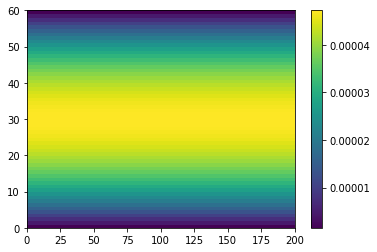

In [13]:
plt.pcolormesh(ux[1:-1,1:-1])
plt.colorbar()

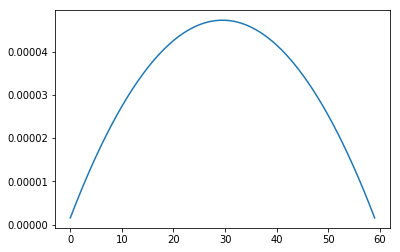

In [14]:
plt.plot(ux[1:-1, 100])  # cross-section, should be parabola

In [15]:
uy.max(), uy.min()  # should be almost zero

(4.121702978922506e-15, -4.538036613157101e-15)

In [16]:
rho.max(), rho.min()  # should be almost one

(1.0, 0.9999999999996085)